In [1]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# GMM clustering libraries
# import sys
# sys.path.insert(0, '../../libraries/')

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpgmm_runjingdev import utils_lib

# BNP libraries: these are pip installed
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib
import bnpmodeling_runjingdev.modeling_lib as modeling_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

import time

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

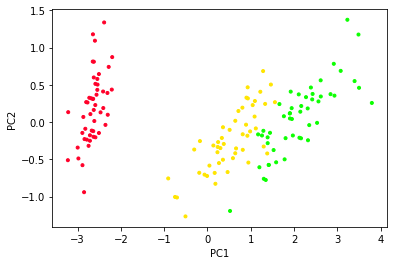

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'alpha': 3.5, 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1460.205125758913

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

375.7671595958129

### Set up KL objective 

In [10]:
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl,
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = \
    lambda x : get_vb_params_loss(features,
                                x, prior_params_dict,
                                 gh_loc, gh_weights)


In [11]:
# # get loss as a function of vb parameters
# get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
# get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                 gh_loc, gh_weights)

# # Get loss as a function vb_free_params
# get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                         patterns=vb_params_paragami,
#                                         free=True)


In [12]:
t0 = time.time()
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

refit_time = time.time() - t0

running bfgs ... 
Iter 0: f = 375.76715960
Iter 1: f = 210.36488351
Iter 2: f = 104.45926359
Iter 3: f = 80.26216065
Iter 4: f = 153.58687837
Iter 5: f = 4.70015773
Iter 6: f = -66.67166543
Iter 7: f = 300.43234958
Iter 8: f = -82.87544175
Iter 9: f = -72.75844559
Iter 10: f = -89.78920488
Iter 11: f = -100.86586978
Iter 12: f = -115.33042188
Iter 13: f = -126.49314373
Iter 14: f = -145.45653822
Iter 15: f = -177.50414967
Iter 16: f = -152.27814721
Iter 17: f = -192.19771140
Iter 18: f = -209.67506448
Iter 19: f = -229.07510499
Iter 20: f = -242.25324487
Iter 21: f = -259.99183334
Iter 22: f = -283.70428751
Iter 23: f = -201.61945442
Iter 24: f = -287.91408905
Iter 25: f = -294.36700181
Iter 26: f = -305.44400804
Iter 27: f = -317.05708008
Iter 28: f = -316.05175713
Iter 29: f = -322.99704461
Iter 30: f = -331.06821601
Iter 31: f = -339.48324280
Iter 32: f = -344.20139215
Iter 33: f = -348.70713371
Iter 34: f = -344.90124636
Iter 35: f = -351.06883659
Iter 36: f = -351.33096379
Iter 37

In [13]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

In [14]:
# plot check results
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

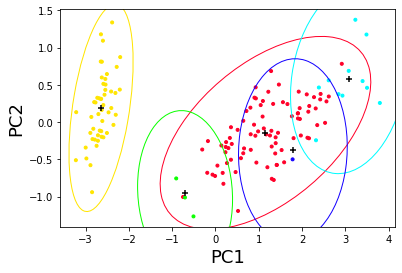

In [15]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [18]:
paragami.save_folded('./iris_fits/iris_fits_alpha{}'.format(prior_params_dict['alpha']), 
                     vb_opt_dict,
                     vb_params_paragami, 
                     alpha = prior_params_dict['alpha'], 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)

# Fit for a range of alpha 

In [19]:
alpha_list = np.arange(start=0.5, stop=16, step=0.5)

print(alpha_list)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


In [20]:
def refit_with_alpha(alpha, vb_opt): 
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # set up new objective, witht the prior changed
#     get_vb_params_loss.cache_args(features, None, prior_params_pert_dict, gh_loc, gh_weights)
#     get_pert_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                             patterns=vb_params_paragami,
#                                             free=True)

    get_vb_params_loss = paragami.FlattenFunctionInput(
                                    original_fun=gmm_lib.get_kl,
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

    get_pert_loss = \
        lambda x : get_vb_params_loss(features,
                                    x, prior_params_pert_dict,
                                     gh_loc, gh_weights)

    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss,deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [21]:
for alpha in alpha_list: 
    print('######################')
    print('re-optimzing with alpha = ', alpha)
    print('######################')
    
    t0 = time.time() 
    
    vb_opt_pert = refit_with_alpha(alpha, vb_opt)
    
    vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)
    
    refit_time = time.time() - t0
    print('refit time: {:.03f}sec'.format(refit_time))
    
    filename = './iris_fits/iris_fits_alpha{}'.format(alpha)
    print('saving results to ', filename)
    paragami.save_folded(filename, 
                     vb_pert_dict,
                     vb_params_paragami, 
                     alpha = alpha, 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)
    


######################
re-optimzing with alpha =  0.5
######################
running bfgs ... 
Iter 0: f = -398.89705687
Iter 1: f = -401.43053943
Iter 2: f = -384.22893096
Iter 3: f = -401.70696123
Iter 4: f = -402.12420008
Iter 5: f = -402.80469758
Iter 6: f = -403.91379619
Iter 7: f = -404.97202538
Iter 8: f = -405.84110246
Iter 9: f = -406.90105854
Iter 10: f = -408.72771190
Iter 11: f = -410.07621782
Iter 12: f = -412.23606708
Iter 13: f = -406.86536723
Iter 14: f = -412.72739370
Iter 15: f = -413.54918524
Iter 16: f = -412.54642995
Iter 17: f = -413.80830269
Iter 18: f = -414.26507053
Iter 19: f = -414.97534613
Iter 20: f = -416.21694423
Iter 21: f = -417.94983746
Iter 22: f = -419.81479871
Iter 23: f = -414.16478532
Iter 24: f = -420.18338629
Iter 25: f = -420.81988348
Iter 26: f = -421.78385308
Iter 27: f = -423.30826711
Iter 28: f = -424.06621799
Iter 29: f = -424.10666977
Iter 30: f = -424.18528850
Iter 31: f = -424.43857972
Iter 32: f = -424.86400255
Iter 33: f = -425.474210

Iter 17: f = -402.66868347
Iter 18: f = -402.90462717
Iter 19: f = -403.26251993
Iter 20: f = -403.87991337
Iter 21: f = -404.67029468
Iter 22: f = -405.37449362
Iter 23: f = -405.94859790
Iter 24: f = -405.65048783
Iter 25: f = -406.17828686
Iter 26: f = -406.59448014
Iter 27: f = -406.42377754
Iter 28: f = -406.76968202
Iter 29: f = -406.99346604
Iter 30: f = -406.82480937
Iter 31: f = -407.07401984
Iter 32: f = -407.21757940
Iter 33: f = -407.34704877
Iter 34: f = -407.55610759
Iter 35: f = -407.70091990
Iter 36: f = -407.75025614
Iter 37: f = -407.82173703
Iter 38: f = -407.90701937
Iter 39: f = -407.98105978
Iter 40: f = -408.04262392
Iter 41: f = -407.99355668
Iter 42: f = -408.06496914
Iter 43: f = -408.05254593
Iter 44: f = -408.07387771
Iter 45: f = -408.08433657
Iter 46: f = -408.08215463
Iter 47: f = -408.08914273
Iter 48: f = -408.09269268
Iter 49: f = -408.09679162
Iter 50: f = -408.10299333
Iter 51: f = -408.10714340
Iter 52: f = -408.11321570
Iter 53: f = -408.12180120
I

Iter 123: f = -395.58622662
Iter 124: f = -395.58622662
Iter 125: f = -395.58622662
Iter 126: f = -395.58622662
Iter 127: f = -395.58622662
Iter 128: f = -395.58622662
Iter 129: f = -395.58622662
Iter 130: f = -395.58622662
Iter 131: f = -395.58622662
Iter 132: f = -395.58622662
Iter 133: f = -395.58622662
Iter 134: f = -395.58622662
Iter 135: f = -395.58622662
Iter 136: f = -395.58622662
Iter 137: f = -395.58622662
Iter 138: f = -395.58622662
Iter 139: f = -395.58622662
Iter 140: f = -395.58622662
Iter 141: f = -395.58622662
Iter 142: f = -395.58622662
Iter 143: f = -395.58622662
Iter 144: f = -395.58622662
Iter 145: f = -395.58622662
Iter 146: f = -395.58622662
Iter 147: f = -395.58622662
Iter 148: f = -395.58622662
Iter 149: f = -395.58622662
Iter 150: f = -395.58622662
Iter 151: f = -395.58622662
Iter 152: f = -395.58622662
Iter 153: f = -395.58622662
Iter 154: f = -395.58622662
Iter 155: f = -395.58622662
Iter 156: f = -395.58622662
Iter 157: f = -395.58622662
Iter 158: f = -395.5

Iter 29: f = -378.15143592
Iter 30: f = -378.15848911
Iter 31: f = -378.17154405
Iter 32: f = -378.18638965
Iter 33: f = -378.19738673
Iter 34: f = -378.21016730
Iter 35: f = -378.19170330
Iter 36: f = -378.21389821
Iter 37: f = -378.21996451
Iter 38: f = -378.22851838
Iter 39: f = -378.22542945
Iter 40: f = -378.23218260
Iter 41: f = -378.23519445
Iter 42: f = -378.23640308
Iter 43: f = -378.23764048
Iter 44: f = -378.23926826
Iter 45: f = -378.23817829
Iter 46: f = -378.23988367
Iter 47: f = -378.24077233
Iter 48: f = -378.24045330
Iter 49: f = -378.24115254
Iter 50: f = -378.24164787
Iter 51: f = -378.24240175
Iter 52: f = -378.24304838
Iter 53: f = -378.24366598
Iter 54: f = -378.24443008
Iter 55: f = -378.24509138
Iter 56: f = -378.24546078
Iter 57: f = -378.24589628
Iter 58: f = -378.24581830
Iter 59: f = -378.24609845
Iter 60: f = -378.24640140
Iter 61: f = -378.24629781
Iter 62: f = -378.24653210
Iter 63: f = -378.24672219
Iter 64: f = -378.24689960
Iter 65: f = -378.24690096
I

Iter 166: f = -371.58338609
Iter 167: f = -371.58338609
Iter 168: f = -371.58338609
Iter 169: f = -371.58338609
Iter 170: f = -371.58338609
Iter 171: f = -371.58338609
Iter 172: f = -371.58338609
Iter 173: f = -371.58338609
Iter 174: f = -371.58338609
Iter 175: f = -371.58338609
Iter 176: f = -371.58338609
Iter 177: f = -371.58338609
Iter 178: f = -371.58338609
Iter 179: f = -371.58338609
Iter 180: f = -371.58338609
Iter 181: f = -371.58338609
Iter 182: f = -371.58338609
Iter 183: f = -371.58338609
Iter 184: f = -371.58338609
Iter 185: f = -371.58338609
Iter 186: f = -371.58338609
Iter 187: f = -371.58338609
         Current function value: -371.583386
         Iterations: 95
         Function evaluations: 188
         Gradient evaluations: 176

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 12.53
running newton steps
Iter 0: f = -371.58338609
Iter 1: f = -371.58338609
Iter 2: f = -371.58338609
Iter 3: f = -371.58338609
Iter 4: f

Iter 22: f = -355.51059940
Iter 23: f = -355.53939258
Iter 24: f = -355.57648259
Iter 25: f = -355.53754597
Iter 26: f = -355.58895958
Iter 27: f = -355.60766395
Iter 28: f = -355.61047750
Iter 29: f = -355.61536542
Iter 30: f = -355.62418033
Iter 31: f = -355.63851908
Iter 32: f = -355.64566124
Iter 33: f = -355.64656652
Iter 34: f = -355.64826992
Iter 35: f = -355.65151660
Iter 36: f = -355.65650236
Iter 37: f = -355.66425783
Iter 38: f = -355.67122086
Iter 39: f = -355.67295782
Iter 40: f = -355.67602389
Iter 41: f = -355.67977575
Iter 42: f = -355.68170955
Iter 43: f = -355.68432919
Iter 44: f = -355.68653426
Iter 45: f = -355.68189925
Iter 46: f = -355.68708067
Iter 47: f = -355.68751093
Iter 48: f = -355.68802138
Iter 49: f = -355.68795760
Iter 50: f = -355.68826402
Iter 51: f = -355.68850980
Iter 52: f = -355.68885685
Iter 53: f = -355.68921739
Iter 54: f = -355.68972394
Iter 55: f = -355.69020048
Iter 56: f = -355.69066060
Iter 57: f = -355.69011678
Iter 58: f = -355.69080701
I

Iter 64: f = -351.29057271
Iter 65: f = -351.29091855
Iter 66: f = -351.29101645
Iter 67: f = -351.29118865
Iter 68: f = -351.29142120
Iter 69: f = -351.29169891
Iter 70: f = -351.29130330
Iter 71: f = -351.29178129
Iter 72: f = -351.29183214
Iter 73: f = -351.29190015
Iter 74: f = -351.29194167
Iter 75: f = -351.29193601
Iter 76: f = -351.29196131
Iter 77: f = -351.29198273
Iter 78: f = -351.29197126
Iter 79: f = -351.29198759
Iter 80: f = -351.29199564
Iter 81: f = -351.29200545
Iter 82: f = -351.29200203
Iter 83: f = -351.29200968
Iter 84: f = -351.29200981
Iter 85: f = -351.29201110
Iter 86: f = -351.29201204
Iter 87: f = -351.29201342
Iter 88: f = -351.29201451
Iter 89: f = -351.29201596
Iter 90: f = -351.29201607
Iter 91: f = -351.29201671
Iter 92: f = -351.29201761
Iter 93: f = -351.29201812
Iter 94: f = -351.29201883
Iter 95: f = -351.29201956
Iter 96: f = -351.29201985
Iter 97: f = -351.29202033
Iter 98: f = -351.29202073
Iter 99: f = -351.29202107
Iter 100: f = -351.29202125


Iter 192: f = -347.20558706
Iter 193: f = -347.20558706
Iter 194: f = -347.20558706
Iter 195: f = -347.20558706
Iter 196: f = -347.20558706
Iter 197: f = -347.20558706
Iter 198: f = -347.20558706
Iter 199: f = -347.20558706
Iter 200: f = -347.20558706
Iter 201: f = -347.20558706
Iter 202: f = -347.20558706
Iter 203: f = -347.20558706
Iter 204: f = -347.20558706
Iter 205: f = -347.20558706
Iter 206: f = -347.20558706
Iter 207: f = -347.20558706
Iter 208: f = -347.20558706
Iter 209: f = -347.20558706
Iter 210: f = -347.20558706
Iter 211: f = -347.20558706
Iter 212: f = -347.20558706
Iter 213: f = -347.20558706
Iter 214: f = -347.20558706
         Current function value: -347.205587
         Iterations: 113
         Function evaluations: 215
         Gradient evaluations: 213

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 11.54
running newton steps
Iter 0: f = -347.20558706
Iter 1: f = -347.20558706
Iter 2: f = -347.20558706
Iter 3

Iter 230: f = -343.38436627
Iter 231: f = -343.38436627
Iter 232: f = -343.38436627
Iter 233: f = -343.38436627
Iter 234: f = -343.38436627
Iter 235: f = -343.38436627
Iter 236: f = -343.38436627
Iter 237: f = -343.38436627
Iter 238: f = -343.38436627
Iter 239: f = -343.38436627
Iter 240: f = -343.38436627
Iter 241: f = -343.38436627
Iter 242: f = -343.38436627
Iter 243: f = -343.38436627
Iter 244: f = -343.38436627
Iter 245: f = -343.38436627
Iter 246: f = -343.38436627
Iter 247: f = -343.38436627
Iter 248: f = -343.38436627
Iter 249: f = -343.38436627
Iter 250: f = -343.38436627
Iter 251: f = -343.38436627
Iter 252: f = -343.38436627
Iter 253: f = -343.38436627
Iter 254: f = -343.38436627
Iter 255: f = -343.38436627
Iter 256: f = -343.38436627
Iter 257: f = -343.38436627
Iter 258: f = -343.38436627
         Current function value: -343.384366
         Iterations: 118
         Function evaluations: 259
         Gradient evaluations: 247

 running preconditioned newton; iter =  0
Compu

Iter 241: f = -339.79095764
Iter 242: f = -339.79095764
Iter 243: f = -339.79095764
Iter 244: f = -339.79095764
Iter 245: f = -339.79095764
Iter 246: f = -339.79095764
Iter 247: f = -339.79095764
Iter 248: f = -339.79095764
Iter 249: f = -339.79095764
Iter 250: f = -339.79095764
Iter 251: f = -339.79095764
         Current function value: -339.790958
         Iterations: 123
         Function evaluations: 252
         Gradient evaluations: 240

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 10.97
running newton steps
Iter 0: f = -339.79095764
Iter 1: f = -339.79095764
Iter 2: f = -339.79095764
Iter 3: f = -339.79095764
Iter 4: f = -339.79095764
Iter 5: f = -339.79095764
Iter 6: f = -339.79095764
Iter 7: f = -339.79095764
Iter 8: f = -339.79095764
Iter 9: f = -339.79095764
Iter 10: f = -339.79095764
Iter 11: f = -339.79095764
Iter 12: f = -339.79095764
Iter 13: f = -339.79095764
Optimization terminated successfully.
         Curre

Iter 2: f = -283.91747823
Iter 3: f = -325.27516774
Iter 4: f = -325.69494852
Iter 5: f = -325.80345820
Iter 6: f = -326.01548219
Iter 7: f = -326.72016124
Iter 8: f = -327.21345860
Iter 9: f = -327.85191711
Iter 10: f = -328.78461770
Iter 11: f = -329.78495787
Iter 12: f = -320.67341635
Iter 13: f = -329.87696563
Iter 14: f = -330.03588179
Iter 15: f = -330.12450518
Iter 16: f = -330.26810219
Iter 17: f = -330.53697897
Iter 18: f = -330.42923185
Iter 19: f = -330.65022234
Iter 20: f = -330.85323290
Iter 21: f = -331.09957375
Iter 22: f = -331.36535054
Iter 23: f = -331.67655327
Iter 24: f = -331.90879189
Iter 25: f = -332.03969903
Iter 26: f = -332.24650915
Iter 27: f = -332.50231541
Iter 28: f = -332.77853713
Iter 29: f = -331.09376362
Iter 30: f = -332.81532400
Iter 31: f = -332.85430192
Iter 32: f = -332.88845770
Iter 33: f = -332.93939999
Iter 34: f = -332.92976249
Iter 35: f = -332.96293475
Iter 36: f = -332.99674153
Iter 37: f = -333.03823668
Iter 38: f = -333.02204294
Iter 39: 

Iter 3: f = -320.62196963
Iter 4: f = -321.13672589
Iter 5: f = -321.27140489
Iter 6: f = -321.53436554
Iter 7: f = -322.40423976
Iter 8: f = -322.95627512
Iter 9: f = -323.69294121
Iter 10: f = -324.78192386
Iter 11: f = -325.96445068
Iter 12: f = -314.23271373
Iter 13: f = -326.06582811
Iter 14: f = -326.24261970
Iter 15: f = -326.36526446
Iter 16: f = -326.55916111
Iter 17: f = -326.91865601
Iter 18: f = -326.57768579
Iter 19: f = -327.04213883
Iter 20: f = -327.26565584
Iter 21: f = -327.55160786
Iter 22: f = -327.87660767
Iter 23: f = -328.23992318
Iter 24: f = -328.57691138
Iter 25: f = -328.69021896
Iter 26: f = -328.88338189
Iter 27: f = -329.16504099
Iter 28: f = -329.49772976
Iter 29: f = -327.39461705
Iter 30: f = -329.54166129
Iter 31: f = -329.60234407
Iter 32: f = -329.65094897
Iter 33: f = -329.73057421
Iter 34: f = -329.81337107
Iter 35: f = -329.84837477
Iter 36: f = -329.90157863
Iter 37: f = -329.93623437
Iter 38: f = -329.96908119
Iter 39: f = -329.98698474
Iter 40:

Iter 2: f = -258.17440885
Iter 3: f = -315.97284996
Iter 4: f = -316.58942861
Iter 5: f = -316.75370228
Iter 6: f = -317.07414804
Iter 7: f = -318.12798052
Iter 8: f = -318.72114094
Iter 9: f = -319.54303872
Iter 10: f = -320.77811152
Iter 11: f = -322.15107900
Iter 12: f = -307.42130075
Iter 13: f = -322.26132964
Iter 14: f = -322.45529043
Iter 15: f = -322.61543299
Iter 16: f = -322.86514641
Iter 17: f = -323.32479651
Iter 18: f = -322.82639623
Iter 19: f = -323.47578997
Iter 20: f = -323.74715851
Iter 21: f = -324.09202319
Iter 22: f = -324.48887745
Iter 23: f = -324.87613961
Iter 24: f = -325.33213208
Iter 25: f = -325.37336476
Iter 26: f = -325.57596060
Iter 27: f = -325.93116187
Iter 28: f = -326.35231958
Iter 29: f = -326.70398720
Iter 30: f = -324.94497819
Iter 31: f = -326.75391705
Iter 32: f = -326.80401762
Iter 33: f = -326.80323079
Iter 34: f = -326.82934185
Iter 35: f = -326.86997422
Iter 36: f = -326.91703762
Iter 37: f = -326.93064920
Iter 38: f = -326.95503032
Iter 39: 

Iter 122: f = -324.43259452
Iter 123: f = -324.43259452
Iter 124: f = -324.43259452
Iter 125: f = -324.43259452
Iter 126: f = -324.43259452
Iter 127: f = -324.43259452
Iter 128: f = -324.43259452
Iter 129: f = -324.43259452
Iter 130: f = -324.43259452
Iter 131: f = -324.43259452
Iter 132: f = -324.43259452
Iter 133: f = -324.43259452
Iter 134: f = -324.43259452
Iter 135: f = -324.43259452
Iter 136: f = -324.43259452
Iter 137: f = -324.43259452
Iter 138: f = -324.43259452
Iter 139: f = -324.43259452
Iter 140: f = -324.43259452
Iter 141: f = -324.43259452
Iter 142: f = -324.43259452
Iter 143: f = -324.43259452
Iter 144: f = -324.43259452
Iter 145: f = -324.43259452
Iter 146: f = -324.43259452
Iter 147: f = -324.43259452
Iter 148: f = -324.43259452
Iter 149: f = -324.43259452
Iter 150: f = -324.43259452
Iter 151: f = -324.43259452
Iter 152: f = -324.43259452
Iter 153: f = -324.43259452
Iter 154: f = -324.43259452
Iter 155: f = -324.43259452
Iter 156: f = -324.43259452
Iter 157: f = -324.4

Iter 195: f = -321.78138839
Iter 196: f = -321.78138839
Iter 197: f = -321.78138839
Iter 198: f = -321.78138839
Iter 199: f = -321.78138839
Iter 200: f = -321.78138839
Iter 201: f = -321.78138839
Iter 202: f = -321.78138839
Iter 203: f = -321.78138839
Iter 204: f = -321.78138839
Iter 205: f = -321.78138839
Iter 206: f = -321.78138839
Iter 207: f = -321.78138839
Iter 208: f = -321.78138839
Iter 209: f = -321.78138839
Iter 210: f = -321.78138839
Iter 211: f = -321.78138839
Iter 212: f = -321.78138839
Iter 213: f = -321.78138839
Iter 214: f = -321.78138839
Iter 215: f = -321.78138839
Iter 216: f = -321.78138839
Iter 217: f = -321.78138839
Iter 218: f = -321.78138839
Iter 219: f = -321.78138839
Iter 220: f = -321.78138839
Iter 221: f = -321.78138839
Iter 222: f = -321.78138839
Iter 223: f = -321.78138839
Iter 224: f = -321.78138839
Iter 225: f = -321.78138839
Iter 226: f = -321.78138839
Iter 227: f = -321.78138839
Iter 228: f = -321.78138839
Iter 229: f = -321.78138839
Iter 230: f = -321.7

Iter 229: f = -319.24433340
Iter 230: f = -319.24433340
Iter 231: f = -319.24433340
Iter 232: f = -319.24433340
Iter 233: f = -319.24433340
Iter 234: f = -319.24433340
Iter 235: f = -319.24433340
Iter 236: f = -319.24433340
Iter 237: f = -319.24433340
Iter 238: f = -319.24433340
Iter 239: f = -319.24433340
Iter 240: f = -319.24433340
Iter 241: f = -319.24433340
Iter 242: f = -319.24433340
Iter 243: f = -319.24433340
Iter 244: f = -319.24433340
Iter 245: f = -319.24433340
Iter 246: f = -319.24433340
Iter 247: f = -319.24433340
Iter 248: f = -319.24433340
Iter 249: f = -319.24433340
Iter 250: f = -319.24433340
Iter 251: f = -319.24433340
Iter 252: f = -319.24433340
Iter 253: f = -319.24433340
Iter 254: f = -319.24433340
Iter 255: f = -319.24433340
Iter 256: f = -319.24433340
Iter 257: f = -319.24433340
Iter 258: f = -319.24433340
Iter 259: f = -319.24433340
Iter 260: f = -319.24433340
Iter 261: f = -319.24433340
Iter 262: f = -319.24433340
Iter 263: f = -319.24433340
Iter 264: f = -319.2

Iter 130: f = -316.81445909
Iter 131: f = -316.81445909
Iter 132: f = -316.81445909
Iter 133: f = -316.81445909
Iter 134: f = -316.81445909
Iter 135: f = -316.81445909
Iter 136: f = -316.81445909
Iter 137: f = -316.81445910
Iter 138: f = -316.81445910
Iter 139: f = -316.81445910
Iter 140: f = -316.81445910
Iter 141: f = -316.81445910
Iter 142: f = -316.81445910
Iter 143: f = -316.81445910
Iter 144: f = -316.81445910
Iter 145: f = -316.81445910
Iter 146: f = -316.81445910
Iter 147: f = -316.81445910
Iter 148: f = -316.81445910
Iter 149: f = -316.81445910
Iter 150: f = -316.81445910
Iter 151: f = -316.81445910
Iter 152: f = -316.81445910
Iter 153: f = -316.81445910
Iter 154: f = -316.81445910
Iter 155: f = -316.81445910
Iter 156: f = -316.81445910
Iter 157: f = -316.81445910
Iter 158: f = -316.81445910
Iter 159: f = -316.81445910
Iter 160: f = -316.81445910
Iter 161: f = -316.81445910
Iter 162: f = -316.81445910
Iter 163: f = -316.81445910
Iter 164: f = -316.81445910
Iter 165: f = -316.8

Iter 187: f = -314.48678965
Iter 188: f = -314.48678965
Iter 189: f = -314.48678965
Iter 190: f = -314.48678965
Iter 191: f = -314.48678965
Iter 192: f = -314.48678965
Iter 193: f = -314.48678965
Iter 194: f = -314.48678965
Iter 195: f = -314.48678965
Iter 196: f = -314.48678965
Iter 197: f = -314.48678965
Iter 198: f = -314.48678965
Iter 199: f = -314.48678965
Iter 200: f = -314.48678965
Iter 201: f = -314.48678965
Iter 202: f = -314.48678965
Iter 203: f = -314.48678965
Iter 204: f = -314.48678965
Iter 205: f = -314.48678965
Iter 206: f = -314.48678965
Iter 207: f = -314.48678965
Iter 208: f = -314.48678965
Iter 209: f = -314.48678965
Iter 210: f = -314.48678965
Iter 211: f = -314.48678965
Iter 212: f = -314.48678965
Iter 213: f = -314.48678965
Iter 214: f = -314.48678965
Iter 215: f = -314.48678965
Iter 216: f = -314.48678965
Iter 217: f = -314.48678965
Iter 218: f = -314.48678965
Iter 219: f = -314.48678965
Iter 220: f = -314.48678965
Iter 221: f = -314.48678965
Iter 222: f = -314.4

Iter 190: f = -312.25752716
Iter 191: f = -312.25752716
Iter 192: f = -312.25752716
Iter 193: f = -312.25752716
Iter 194: f = -312.25752716
Iter 195: f = -312.25752716
Iter 196: f = -312.25752716
Iter 197: f = -312.25752716
Iter 198: f = -312.25752716
Iter 199: f = -312.25752716
Iter 200: f = -312.25752716
Iter 201: f = -312.25752716
Iter 202: f = -312.25752716
Iter 203: f = -312.25752716
Iter 204: f = -312.25752716
Iter 205: f = -312.25752716
Iter 206: f = -312.25752716
Iter 207: f = -312.25752716
Iter 208: f = -312.25752716
Iter 209: f = -312.25752716
Iter 210: f = -312.25752716
Iter 211: f = -312.25752716
Iter 212: f = -312.25752716
Iter 213: f = -312.25752716
Iter 214: f = -312.25752716
Iter 215: f = -312.25752716
Iter 216: f = -312.25752716
Iter 217: f = -312.25752716
Iter 218: f = -312.25752716
Iter 219: f = -312.25752716
Iter 220: f = -312.25752716
Iter 221: f = -312.25752716
Iter 222: f = -312.25752716
Iter 223: f = -312.25752716
Iter 224: f = -312.25752716
Iter 225: f = -312.2

Iter 222: f = -310.12421374
Iter 223: f = -310.12421374
Iter 224: f = -310.12421374
Iter 225: f = -310.12421374
Iter 226: f = -310.12421374
Iter 227: f = -310.12421374
Iter 228: f = -310.12421374
Iter 229: f = -310.12421374
Iter 230: f = -310.12421374
Iter 231: f = -310.12421374
Iter 232: f = -310.12421374
Iter 233: f = -310.12421374
Iter 234: f = -310.12421374
Iter 235: f = -310.12421374
Iter 236: f = -310.12421374
Iter 237: f = -310.12421374
Iter 238: f = -310.12421374
Iter 239: f = -310.12421374
         Current function value: -310.124214
         Iterations: 134
         Function evaluations: 240
         Gradient evaluations: 226

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 11.72
running newton steps
Iter 0: f = -310.12421374
Iter 1: f = -310.12421374
Optimization terminated successfully.
         Current function value: -310.124214
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2


Iter 251: f = -308.08626047
Iter 252: f = -308.08626047
Iter 253: f = -308.08626047
Iter 254: f = -308.08626047
Iter 255: f = -308.08626047
Iter 256: f = -308.08626047
Iter 257: f = -308.08626047
Iter 258: f = -308.08626047
Iter 259: f = -308.08626047
Iter 260: f = -308.08626047
Iter 261: f = -308.08626047
Iter 262: f = -308.08626047
Iter 263: f = -308.08626047
Iter 264: f = -308.08626047
         Current function value: -308.086260
         Iterations: 131
         Function evaluations: 265
         Gradient evaluations: 253

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 11.21
running newton steps
Iter 0: f = -308.08626047
Iter 1: f = -308.08626047
Optimization terminated successfully.
         Current function value: -308.086260
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 2
Iter 0: x_diff = 6.409999513244448e-05, f_diff = 2.6147972675971687e-12, grad_l1

Iter 4: f = -271.58719519
Iter 5: f = -272.15226969
Iter 6: f = -273.24658806
Iter 7: f = -276.67906016
Iter 8: f = -276.68120463
Iter 9: f = -278.89989207
Iter 10: f = -281.27948111
Iter 11: f = -284.74536324
Iter 12: f = -287.76453594
Iter 13: f = -248.41649132
Iter 14: f = -287.97022730
Iter 15: f = -288.34240602
Iter 16: f = -288.81649891
Iter 17: f = -289.62940003
Iter 18: f = -291.05744808
Iter 19: f = -289.62171438
Iter 20: f = -291.53899335
Iter 21: f = -292.36664487
Iter 22: f = -293.24644026
Iter 23: f = -294.53083048
Iter 24: f = -295.67382303
Iter 25: f = -297.42903141
Iter 26: f = -298.27682542
Iter 27: f = -299.57623924
Iter 28: f = -298.72405945
Iter 29: f = -300.05694362
Iter 30: f = -300.65414557
Iter 31: f = -299.98358003
Iter 32: f = -300.84419323
Iter 33: f = -301.16343524
Iter 34: f = -301.68648901
Iter 35: f = -300.77136247
Iter 36: f = -301.82523432
Iter 37: f = -302.04716618
Iter 38: f = -302.17366407
Iter 39: f = -302.38427554
Iter 40: f = -302.64850653
Iter 41

Iter 36: f = -299.51527523
Iter 37: f = -299.99206038
Iter 38: f = -300.24842509
Iter 39: f = -300.58989085
Iter 40: f = -300.75303752
Iter 41: f = -300.97084725
Iter 42: f = -301.16837276
Iter 43: f = -301.29947791
Iter 44: f = -301.43215854
Iter 45: f = -301.58806228
Iter 46: f = -301.59408957
Iter 47: f = -301.67033545
Iter 48: f = -301.76792297
Iter 49: f = -301.82706169
Iter 50: f = -301.90597021
Iter 51: f = -301.97562451
Iter 52: f = -302.02175947
Iter 53: f = -302.07690876
Iter 54: f = -302.13679390
Iter 55: f = -302.17887468
Iter 56: f = -302.22682596
Iter 57: f = -302.27590601
Iter 58: f = -302.31317616
Iter 59: f = -302.34445878
Iter 60: f = -302.38013005
Iter 61: f = -302.41864108
Iter 62: f = -302.43595109
Iter 63: f = -302.45303496
Iter 64: f = -302.47140100
Iter 65: f = -302.48710029
Iter 66: f = -302.49518632
Iter 67: f = -302.50568286
Iter 68: f = -302.51835949
Iter 69: f = -302.52064004
Iter 70: f = -302.52468573
Iter 71: f = -302.53131582
Iter 72: f = -302.53749317
I

Iter 83: f = -300.89260106
Iter 84: f = -300.89310184
Iter 85: f = -300.89336736
Iter 86: f = -300.89370656
Iter 87: f = -300.89349030
Iter 88: f = -300.89383362
Iter 89: f = -300.89397003
Iter 90: f = -300.89407796
Iter 91: f = -300.89414902
Iter 92: f = -300.89421977
Iter 93: f = -300.89425246
Iter 94: f = -300.89426869
Iter 95: f = -300.89429401
Iter 96: f = -300.89431417
Iter 97: f = -300.89431705
Iter 98: f = -300.89432240
Iter 99: f = -300.89433050
Iter 100: f = -300.89434122
Iter 101: f = -300.89434586
Iter 102: f = -300.89434618
Iter 103: f = -300.89434828
Iter 104: f = -300.89435137
Iter 105: f = -300.89435314
Iter 106: f = -300.89435556
Iter 107: f = -300.89435700
Iter 108: f = -300.89435622
Iter 109: f = -300.89435757
Iter 110: f = -300.89435832
Iter 111: f = -300.89435868
Iter 112: f = -300.89435904
Iter 113: f = -300.89435928
Iter 114: f = -300.89435907
Iter 115: f = -300.89435937
Iter 116: f = -300.89435952
Iter 117: f = -300.89435968
Iter 118: f = -300.89435967
Iter 119:

Iter 166: f = -303.46184688
Iter 167: f = -303.46184691
Iter 168: f = -303.46184692
Iter 169: f = -303.46184692
Iter 170: f = -303.46184692
Iter 171: f = -303.46184693
Iter 172: f = -303.46184693
Iter 173: f = -303.46184693
Iter 174: f = -303.46184693
Iter 175: f = -303.46184693
Iter 176: f = -303.46184693
Iter 177: f = -303.46184693
Iter 178: f = -303.46184693
Iter 179: f = -303.46184693
Iter 180: f = -303.46184693
Iter 181: f = -303.46184693
Iter 182: f = -303.46184693
Iter 183: f = -303.46184693
Iter 184: f = -303.46184693
Iter 185: f = -303.46184693
Iter 186: f = -303.46184693
Iter 187: f = -303.46184693
Iter 188: f = -303.46184693
Iter 189: f = -303.46184693
Iter 190: f = -303.46184693
Iter 191: f = -303.46184693
Iter 192: f = -303.46184693
Iter 193: f = -303.46184693
Iter 194: f = -303.46184693
Iter 195: f = -303.46184693
Iter 196: f = -303.46184693
Iter 197: f = -303.46184693
Iter 198: f = -303.46184693
Iter 199: f = -303.46184693
Iter 200: f = -303.46184693
Iter 201: f = -303.4

Iter 162: f = -302.58805551
Iter 163: f = -302.58805550
Iter 164: f = -302.58805553
Iter 165: f = -302.58805554
Iter 166: f = -302.58805555
Iter 167: f = -302.58805555
Iter 168: f = -302.58805556
Iter 169: f = -302.58805556
Iter 170: f = -302.58805556
Iter 171: f = -302.58805556
Iter 172: f = -302.58805556
Iter 173: f = -302.58805557
Iter 174: f = -302.58805556
Iter 175: f = -302.58805557
Iter 176: f = -302.58805557
Iter 177: f = -302.58805557
Iter 178: f = -302.58805557
Iter 179: f = -302.58805557
Iter 180: f = -302.58805557
Iter 181: f = -302.58805557
Iter 182: f = -302.58805557
Iter 183: f = -302.58805557
Iter 184: f = -302.58805557
Iter 185: f = -302.58805557
Iter 186: f = -302.58805557
Iter 187: f = -302.58805557
Iter 188: f = -302.58805557
Iter 189: f = -302.58805557
Iter 190: f = -302.58805557
Iter 191: f = -302.58805557
Iter 192: f = -302.58805557
Iter 193: f = -302.58805557
Iter 194: f = -302.58805557
Iter 195: f = -302.58805557
Iter 196: f = -302.58805557
Iter 197: f = -302.5

In [22]:
print('Done!')

Done!
